### Multi Year Example

In [3]:
#pip install -e . --no-deps

import geowombat as gw
from geowombat.core import dask_to_xarray
from geowombat.data import l8_224078_20200518, l8_224078_20200518_polygons
import xarray as xr 
import numpy as np
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import sys
sys.path.append('/home/mmann1123/Documents/github/xr_fresh/')

#from xr_fresh.transformers import Stackerizer 
from sklearn_xarray import wrap, Target
from sklearn_xarray.preprocessing import Splitter, Sanitizer, Featurizer, Reducer
from sklearn_xarray.model_selection import CrossValidatorWrapper
from sklearn_xarray.datasets import load_wisdm_dataarray
from sklearn.preprocessing import StandardScaler, LabelEncoder,LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from geowombat.ml import Stackerizer

In [4]:
# adding observations so we can play with repeated classes

poly = gpd.read_file(l8_224078_20200518_polygons)
poly2 = poly.copy()
poly2.geometry = poly.buffer(100)
poly2 =gpd.overlay(poly2,poly, how='difference')
polygons = poly.append(poly2)
polygons.reset_index(inplace=True, drop =True)
polygons

# create numeric labels 
polygons['id'] = range(len(polygons))
le = LabelEncoder()
polygons['lu'] = le.fit(polygons.name).transform(polygons.name)
polygons

,name,geometry,id,lu
0,water,"POLYGON ((737544.502 -2795232.772, 737544.502 ...",0,3
1,crop,"POLYGON ((742517.658 -2798160.232, 743046.717 ...",1,0
2,tree,"POLYGON ((742435.360 -2801875.403, 742458.874 ...",2,2
3,developed,"POLYGON ((738903.667 -2811573.845, 738926.586 ...",3,1
4,water,"POLYGON ((737549.496 -2795132.897, 738019.771 ...",4,3
5,crop,"POLYGON ((742427.284 -2798117.423, 742533.096 ...",5,0
6,tree,"POLYGON ((742441.065 -2801775.566, 742852.555 ...",6,2
7,developed,"POLYGON ((738900.098 -2811473.909, 739156.791 ...",7,1


In [5]:
with gw.open([l8_224078_20200518, l8_224078_20200518, l8_224078_20200518], time_names=['t1', 't2', 't3'], stack_dim='time', chunks=50) as src:
    
    poly_array = gw.polygon_to_array(polygons, col='id', data=src )
    print(np.unique(poly_array.sel(band=1).values))
    poly_array = xr.concat([poly_array]*src.gw.ntime, dim='band').assign_coords({'band': src.time.values.tolist()})
    poly_array = poly_array.where(poly_array != 0)
    src.coords['land_use'] = (["time", "y", "x"], poly_array)
    print(src)

[0 1 2 3 4 5 6 7]
<xarray.DataArray (time: 3, band: 3, y: 1860, x: 2041)>
dask.array<concatenate, shape=(3, 3, 1860, 2041), dtype=uint16, chunksize=(1, 3, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * y         (y) float64 -2.777e+06 -2.777e+06 ... -2.833e+06 -2.833e+06
  * band      (band) int64 1 2 3
  * x         (x) float64 7.174e+05 7.174e+05 7.174e+05 ... 7.785e+05 7.786e+05
  * time      (time) <U2 't1' 't2' 't3'
    land_use  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    transform:      (30.0, 0.0, 717345.0, 0.0, -30.0, -2776995.0)
    crs:            +init=epsg:32621
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan, nan, nan)
    scales:         (1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area
    filename:       ['LC08_L1TP_224078_20200518_20200518_01_RT.TIF', 'LC08_L1...
    resampling:     nearest


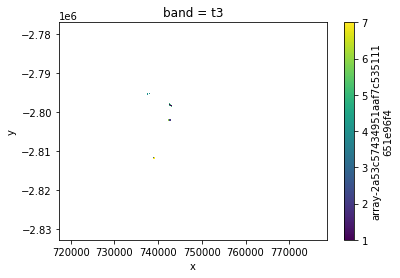

In [6]:
poly_array.sel(band='t3').plot.imshow()

In [7]:
X = Stackerizer(stack_dims = ('y','x','time'), direction='stack').fit_transform(src)   # NOTE stack y before x!!! 

In [8]:
#drop nans from landuse
Xna = X[~X.land_use.isnull()]


figure out how to groupby mean by id 

In [9]:
Xgp = Xna.groupby('land_use').mean('sample')
Xgp

<xarray.DataArray (land_use: 7, band: 3)>
dask.array<stack, shape=(7, 3), dtype=float64, chunksize=(1, 3), chunktype=numpy.ndarray>
Coordinates:
  * band      (band) int64 1 2 3
  * land_use  (land_use) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0

In [10]:
pl = Pipeline(
    [  
       #("sanitizer", Sanitizer(dim='band')),    # Remove elements containing NaNs. might be remove bands if they have nan? 
       ("featurizer", Featurizer()),  # Stack all dimensions and variables except for sample dimension.
#       ('resample', resample( n_samples=250, replace=False,   random_state=0)),
       ("scaler", wrap(StandardScaler)), # zscores , ?wrap if xarray.self required? 
        ("pca", wrap(PCA, reshapes="feature")), 
       ("cls", wrap(GaussianNB, reshapes="feature")),
    ]
)

cv = CrossValidatorWrapper(
    GroupShuffleSplit(n_splits=1, test_size=0.5), groupby=["time"]
)


gs = GridSearchCV(
    pl, cv=cv,   verbose=1, param_grid={"pca__n_components": [5]}
)

y = Target(
    coord="land_use", transform_func=LabelEncoder().fit_transform,dim="sample" )(Xna)


gs.fit(Xna, y) 

#print("Best parameters: {0}".format(gs.best_params_))
print("Accuracy: {0}".format(gs.best_score_))

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished


Accuracy: 0.7405475880052151


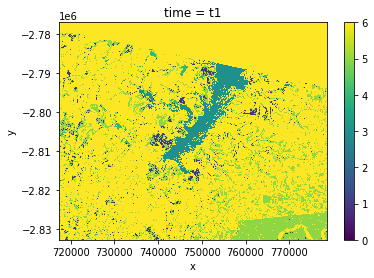

In [11]:
#%% predict 
yp = gs.predict(X)
yp = yp.unstack("sample")
yp.sel(time='t1').plot.imshow()


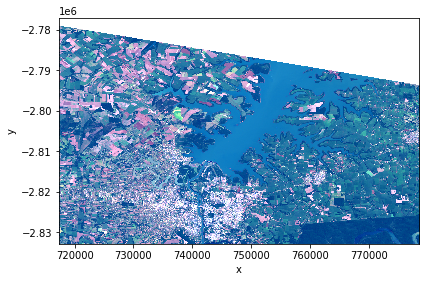

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
with gw.open(l8_224078_20200518) as src:
    src.where(src != 0).sel(band=[3, 2, 1]).plot.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

In [ ]:
yp = gs.predict(X)
yp.values = LabelEncoder().fit(X.land_use).classes_[yp]
yp = yp.unstack("sample")
print(yp)

### Example from geowombat 

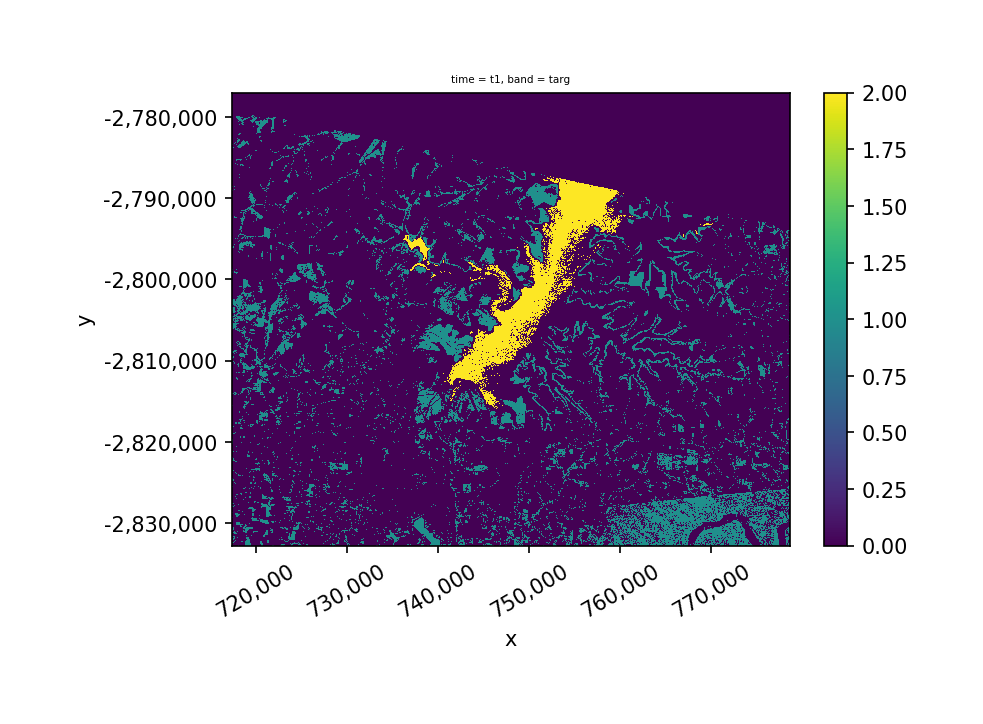

In [10]:
import geowombat as gw
from geowombat.data import l8_224078_20200518, l8_224078_20200518_polygons
from geowombat.ml import fit_predict

import geopandas as gpd
from sklearn_xarray.preprocessing import Featurizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
 
le = LabelEncoder()

labels = gpd.read_file(l8_224078_20200518_polygons)
labels['lc'] = le.fit(labels.name).transform(labels.name)


pl = Pipeline([('featurizer', Featurizer()),
                ('scaler', StandardScaler()),
                ('pca', PCA()),
                ('clf', GaussianNB())])

with gw.open(l8_224078_20200518) as src:
     y = fit_predict(src, labels, pl, col='lc')
     y.isel(time=0).sel(band='targ').gw.imshow()

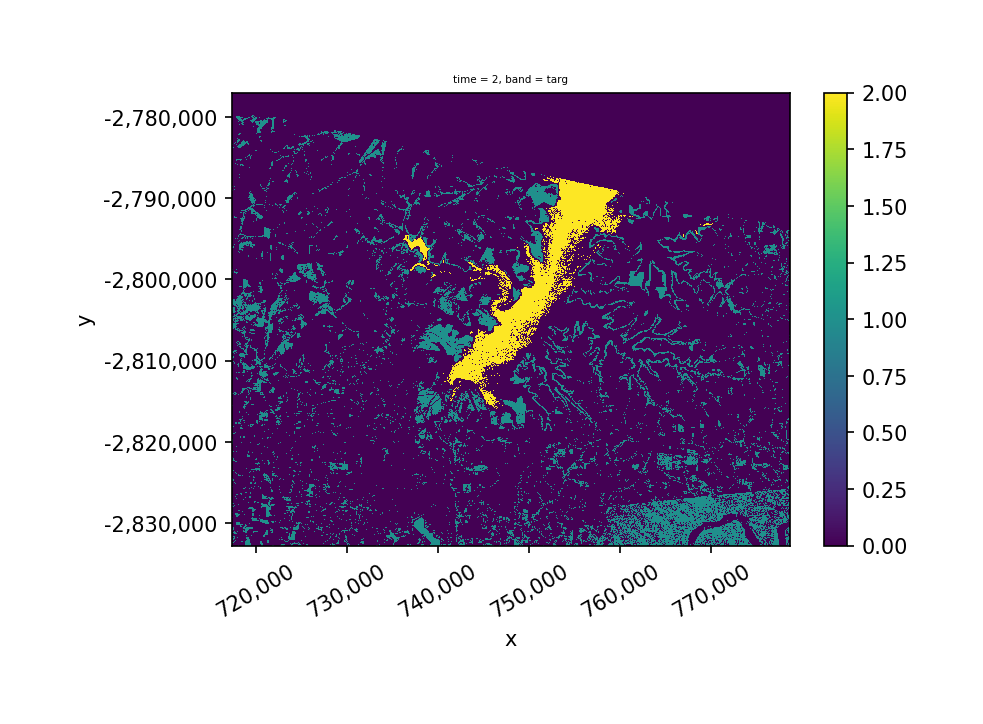

In [11]:
pl = Pipeline([('featurizer', Featurizer()),
                ('scaler', StandardScaler()),
                ('pca', PCA()),
                ('clf', GaussianNB())])

with gw.open([l8_224078_20200518,l8_224078_20200518,l8_224078_20200518] ) as src:
     y = fit_predict(src, labels, pl, col='lc')
     y.isel(time=1).sel(band='targ').gw.imshow()

In [48]:
# trying to get link between unique id and class
from sklearn.preprocessing import OrdinalEncoder
X = [[x,y] for x,y in zip(polygons.name,polygons.id)]
enc = OrdinalEncoder()
enc.fit(X)
print(enc.categories_)
enc.transform(X)

[array(['crop', 'developed', 'tree', 'water'], dtype=object), array([0, 1, 2, 3, 4, 5, 6, 7], dtype=object)]


array([[3., 0.],
       [0., 1.],
       [2., 2.],
       [1., 3.],
       [3., 4.],
       [0., 5.],
       [2., 6.],
       [1., 7.]])